--- GC=F データ取得中 ---


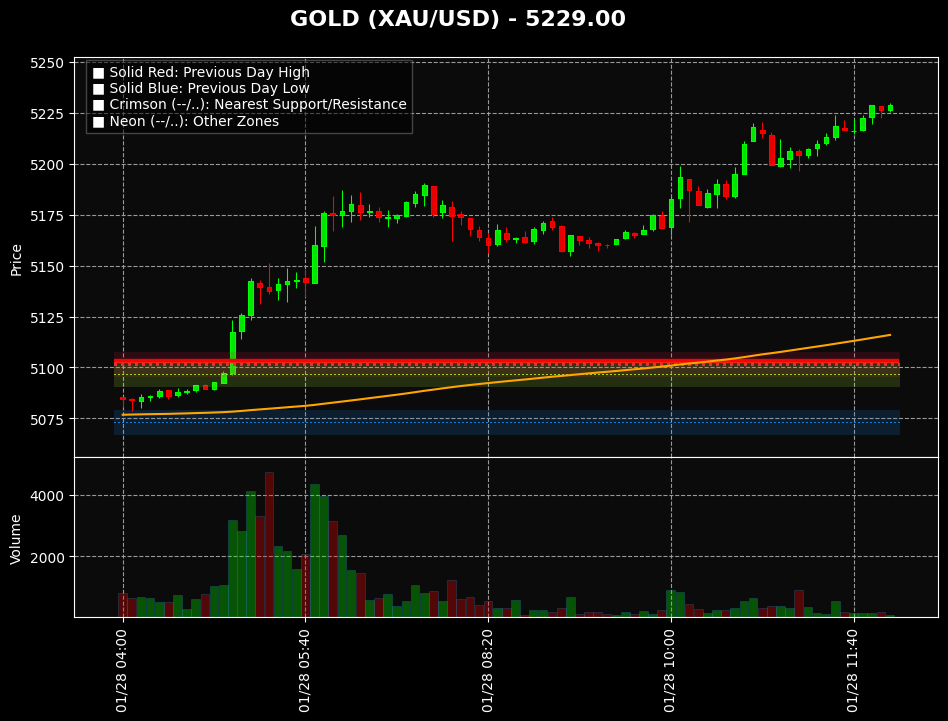

現在価格: 5229.00
★直近サポート(Crimson): 5101.80


In [1]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np
from datetime import timedelta
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

class GoldChartGenerator:
    def __init__(self, symbol="GC=F"):
        self.symbol = symbol
        self.df = None
    
    def fetch_data(self, period="5d", interval="5m"):
        print(f"--- {self.symbol} データ取得中 ---")
        try:
            df = yf.download(self.symbol, interval=interval, period=period, progress=False)
            if df.empty: return None
            
            if isinstance(df.columns, pd.MultiIndex): 
                df.columns = df.columns.get_level_values(0)
            
            for col in ["Open", "High", "Low", "Close", "Volume"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            
            df.dropna(inplace=True)
            if df.index.tz is None: 
                df.index = df.index.tz_localize('UTC')
            df.index = df.index.tz_convert('Asia/Tokyo')
            df.index.name = "Datetime"
            
            df['MA200'] = df['Close'].rolling(window=200).mean()
            self.df = df
            return df
        except Exception as e:
            print(f"データ取得エラー: {e}")
            return None

    def _get_yesterday_levels(self):
        """昨日の高安"""
        if self.df is None: return None, None
        last_date = self.df.index[-1].date()
        prev_data = self.df[self.df.index.date < last_date]
        if prev_data.empty: return None, None
        
        target_date = prev_data.index[-1].date()
        target = prev_data[prev_data.index.date == target_date]
        return target['High'].max(), target['Low'].min()

    def _get_strong_levels(self, df, window=15, merge_dist=2.5, min_touches=3):
        """強いサポレジの抽出"""
        levels = []
        for col, comp in [('High', np.greater), ('Low', np.less)]:
            vals = df[col].values
            idxs = argrelextrema(vals, comparator=comp, order=window)[0]
            for idx in idxs:
                levels.append(df.iloc[idx][col])
        
        levels.sort()
        if not levels: return []

        clusters = []
        if levels:
            current_cluster = [levels[0]]
            for i in range(1, len(levels)):
                if levels[i] - current_cluster[-1] < merge_dist:
                    current_cluster.append(levels[i])
                else:
                    clusters.append(current_cluster)
                    current_cluster = [levels[i]]
            clusters.append(current_cluster)

        strong_zones = []
        for cluster in clusters:
            if len(cluster) >= min_touches:
                strong_zones.append(np.mean(cluster))
        return strong_zones

    def generate_chart(self, display_hours=8):
        if self.df is None:
            print("データがありません")
            return
        
        # 表示用データ
        plot_start = self.df.index[-1] - timedelta(hours=display_hours)
        df_plot = self.df[self.df.index >= plot_start].copy()
        if df_plot.empty: return

        current_price = self.df['Close'].iloc[-1]
        
        # 画面範囲計算
        view_max = df_plot['High'].max()
        view_min = df_plot['Low'].min()
        margin_price = (view_max - view_min) * 0.15
        y_top = view_max + margin_price
        y_bottom = view_min - margin_price

        # サポレジ取得
        y_high, y_low = self._get_yesterday_levels()
        levels = self._get_strong_levels(self.df, window=15, merge_dist=2.5, min_touches=3)
        
        res_levels = [x for x in levels if x > current_price]
        sup_levels = [x for x in levels if x < current_price]
        
        res_levels.sort()
        sup_levels.sort(reverse=True)
        
        # --- 描画設定 ---
        h_lines = []
        h_colors = []
        h_styles = []
        h_widths = []
        h_alphas = []

        # カラーパレット（ネオン系）
        NEON_COLORS = ['#FFD700', '#00FFFF', '#FF00FF', '#ADFF2F', '#1E90FF']

        # 1. 昨日の高安（最強・赤青固定）
        if y_high:
            h_lines.extend([y_high, y_high])
            h_colors.extend(['red', 'red'])
            h_styles.extend(['-', '-'])
            h_widths.extend([3.0, 1.5])
            h_alphas.extend([0.2, 1.0])
        
        if y_low:
            h_lines.extend([y_low, y_low])
            h_colors.extend(['blue', 'blue'])
            h_styles.extend(['-', '-'])
            h_widths.extend([3.0, 1.5])
            h_alphas.extend([0.2, 1.0])

        # 2. レジスタンス（上）
        for i, level in enumerate(res_levels):
            if level > y_top: continue 
            
            # ★最重要変更点：直近（i=0）はクリムゾン固定
            if i == 0:
                color = '#DC143C' # Crimson
                line_alpha = 1.0
                width = 2.0
            else:
                color = NEON_COLORS[i % len(NEON_COLORS)]
                line_alpha = 0.8
                width = 1.0

            # 帯
            h_lines.append(level); h_colors.append(color); h_styles.append('-'); h_widths.append(18.0); h_alphas.append(0.15)
            # 線
            h_lines.append(level); h_colors.append(color); h_styles.append('--'); h_widths.append(width); h_alphas.append(line_alpha)

        # 3. サポート（下）
        for i, level in enumerate(sup_levels):
            if level < y_bottom: continue

            # ★最重要変更点：直近（i=0）はクリムゾン固定
            if i == 0:
                color = '#DC143C' # Crimson
                line_alpha = 1.0
                width = 2.0
            else:
                color = NEON_COLORS[(i + 2) % len(NEON_COLORS)] # 色被り防止でずらす
                line_alpha = 0.8
                width = 1.0
            
            # 帯
            h_lines.append(level); h_colors.append(color); h_styles.append('-'); h_widths.append(18.0); h_alphas.append(0.15)
            # 線
            h_lines.append(level); h_colors.append(color); h_styles.append(':'); h_widths.append(width); h_alphas.append(line_alpha)

        # --- プロット ---
        ma200_slice = self.df.loc[df_plot.index, 'MA200']
        ap = [mpf.make_addplot(ma200_slice, color='orange', width=1.5)]

        # ★Volumeの色修正：inheritにして、alphaを下げる
        mc = mpf.make_marketcolors(
            up='#00ff00', down='#ff0000',
            edge='inherit', wick='inherit',
            volume='inherit', # ローソク足の色を引き継ぐ
        )
        s = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc)

        plot_args = {
            "type": "candle",
            "volume": True,
            "style": s,
            "addplot": ap,
            "datetime_format": "%m/%d %H:%M",
            "xrotation": 90,
            "figsize": (12, 8),
            "ylim": (y_bottom, y_top),
            "returnfig": True,
            "volume_alpha": 0.3 # ★ここでVolumeの透明度を指定（薄くなる）
        }
        
        if h_lines:
            plot_args["hlines"] = dict(hlines=h_lines, colors=h_colors, linestyle=h_styles, linewidths=h_widths, alpha=h_alphas)
            
        plot_args["warn_too_much_data"] = 10000 

        fig, axes = mpf.plot(df_plot, **plot_args)
        
        # タイトル
        fig.suptitle(f"GOLD (XAU/USD) - {current_price:.2f}", fontsize=16, color='white', y=0.94, weight='bold')
        
        # --- ★凡例（説明書き）を追加 ---
        # チャートの左上にテキストを描画
        legend_text = (
            "■ Solid Red: Previous Day High\n"
            "■ Solid Blue: Previous Day Low\n"
            "■ Crimson (--/..): Nearest Support/Resistance\n"
            "■ Neon (--/..): Other Zones"
        )
        # axes[0]が価格チャート
        axes[0].text(
            0.02, 0.98, legend_text, 
            transform=axes[0].transAxes, 
            fontsize=10, 
            color='white', 
            verticalalignment='top',
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='gray')
        )

        # 枠線白化
        for ax in axes:
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white') 
            ax.spines['left'].set_color('white')
            ax.spines['right'].set_color('white')
            ax.tick_params(axis='x', colors='white')
            ax.tick_params(axis='y', colors='white')

        plt.show()

        print(f"現在価格: {current_price:.2f}")
        if res_levels: print(f"★直近レジスタンス(Crimson): {res_levels[0]:.2f}")
        if sup_levels: print(f"★直近サポート(Crimson): {sup_levels[0]:.2f}")

if __name__ == "__main__":
    gen = GoldChartGenerator()
    df = gen.fetch_data(period="5d", interval="5m")
    if df is not None:
        gen.generate_chart(display_hours=8)

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.signal import argrelextrema
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class GoldChartGeneratorPlotly:
    def __init__(self, symbol="GC=F"):
        self.symbol = symbol
        self.df = None
    
    def fetch_data(self, period="5d", interval="5m"):
        print(f"--- {self.symbol} データ取得中 ---")
        try:
            # yfinanceでデータ取得
            df = yf.download(self.symbol, interval=interval, period=period, progress=False)
            if df.empty: return None
            
            # MultiIndexカラム対策
            if isinstance(df.columns, pd.MultiIndex): 
                df.columns = df.columns.get_level_values(0)
            
            # 数値変換
            for col in ["Open", "High", "Low", "Close", "Volume"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            
            df.dropna(inplace=True)
            
            # タイムゾーン処理（日本時間へ）
            if df.index.tz is None: 
                df.index = df.index.tz_localize('UTC')
            df.index = df.index.tz_convert('Asia/Tokyo')
            df.index.name = "Datetime"
            
            # テクニカル指標
            df['MA200'] = df['Close'].rolling(window=200).mean()
            self.df = df
            return df
        except Exception as e:
            print(f"データ取得エラー: {e}")
            return None

    def _get_yesterday_levels(self):
        """昨日の高安取得"""
        if self.df is None: return None, None
        last_date = self.df.index[-1].date()
        prev_data = self.df[self.df.index.date < last_date]
        if prev_data.empty: return None, None
        
        target_date = prev_data.index[-1].date()
        target = prev_data[prev_data.index.date == target_date]
        return target['High'].max(), target['Low'].min()

    def _get_strong_levels(self, df, window=15, merge_dist=2.5, min_touches=3):
        """強いサポレジ抽出（ロジック変更なし）"""
        levels = []
        for col, comp in [('High', np.greater), ('Low', np.less)]:
            vals = df[col].values
            idxs = argrelextrema(vals, comparator=comp, order=window)[0]
            for idx in idxs:
                levels.append(df.iloc[idx][col])
        
        levels.sort()
        if not levels: return []

        clusters = []
        if levels:
            current_cluster = [levels[0]]
            for i in range(1, len(levels)):
                if levels[i] - current_cluster[-1] < merge_dist:
                    current_cluster.append(levels[i])
                else:
                    clusters.append(current_cluster)
                    current_cluster = [levels[i]]
            clusters.append(current_cluster)

        strong_zones = []
        for cluster in clusters:
            if len(cluster) >= min_touches:
                strong_zones.append(np.mean(cluster))
        return strong_zones

    def generate_chart(self, display_hours=8):
        if self.df is None:
            print("データがありません")
            return
        
        current_price = self.df['Close'].iloc[-1]
        
        # サポレジ計算
        y_high, y_low = self._get_yesterday_levels()
        levels = self._get_strong_levels(self.df, window=15, merge_dist=2.5, min_touches=3)
        
        res_levels = sorted([x for x in levels if x > current_price])
        sup_levels = sorted([x for x in levels if x < current_price], reverse=True)

        # 全データを使用するが、初期表示範囲（Zoom）だけ直近にするための計算
        last_time = self.df.index[-1]
        start_zoom_time = last_time - timedelta(hours=display_hours)
        
        # --- Plotly 描画開始 ---
        
        # サブプロット作成（設定は以前と同じ）
        fig = make_subplots(
            rows=2, cols=1, 
            shared_xaxes=True, 
            vertical_spacing=0.03, 
            row_heights=[0.8, 0.2],
            specs=[[{"secondary_y": False}], [{"secondary_y": False}]]
        )

        # 1. ローソク足（日本語ラベル）
        fig.add_trace(go.Candlestick(
            x=self.df.index,
            open=self.df['Open'], high=self.df['High'],
            low=self.df['Low'], close=self.df['Close'],
            name='価格',
            increasing_line_color='#00ff00', decreasing_line_color='#ff0000'
        ), row=1, col=1)

        # 2. MA200
        fig.add_trace(go.Scatter(
            x=self.df.index, y=self.df['MA200'],
            mode='lines', name='200SMA',
            line=dict(color='orange', width=1.5)
        ), row=1, col=1)

        # 3. 出来高
        colors_vol = ['#00ff00' if c >= o else '#ff0000' 
                      for c, o in zip(self.df['Close'], self.df['Open'])]
        
        fig.add_trace(go.Bar(
            x=self.df.index, y=self.df['Volume'],
            name='出来高',
            marker_color=colors_vol,
            opacity=0.5
        ), row=2, col=1)

        # 水平線描画関数
        def add_level_line(fig, price, color, style, width, label, is_zone=False):
            # ゾーン（帯）
            if is_zone:
                fig.add_shape(type="line",
                    x0=self.df.index[0], x1=self.df.index[-1], # 全期間に引く
                    y0=price, y1=price,
                    line=dict(color=color, width=15),
                    opacity=0.15,
                    layer="below", row=1, col=1
                )
            
            # 線
            fig.add_shape(type="line",
                x0=self.df.index[0], x1=self.df.index[-1], # 全期間に引く
                y0=price, y1=price,
                line=dict(color=color, width=width, dash=style),
                opacity=1.0,
                row=1, col=1
            )
            
            # ラベル（最新の足の横に表示）
            fig.add_annotation(
                x=self.df.index[-1], y=price,
                text=f"{label}: {price:.1f}",
                showarrow=False,
                xanchor="left",
                font=dict(color=color, size=10),
                row=1, col=1
            )

        NEON_COLORS = ['#FFD700', '#00FFFF', '#FF00FF', '#ADFF2F', '#1E90FF']

        # A. 昨日の高安
        if y_high: add_level_line(fig, y_high, 'red', 'solid', 2, "前日高値")
        if y_low: add_level_line(fig, y_low, 'blue', 'solid', 2, "前日安値")

        # B. レジスタンス
        for i, level in enumerate(res_levels):
            if i == 0:
                add_level_line(fig, level, '#DC143C', 'dash', 2, "レジ(直近)", is_zone=True)
            else:
                col = NEON_COLORS[i % len(NEON_COLORS)]
                add_level_line(fig, level, col, 'dot', 1, "レジ", is_zone=True)

        # C. サポート
        for i, level in enumerate(sup_levels):
            if i == 0:
                add_level_line(fig, level, '#DC143C', 'dot', 2, "サポ(直近)", is_zone=True)
            else:
                col = NEON_COLORS[(i + 2) % len(NEON_COLORS)]
                add_level_line(fig, level, col, 'dot', 1, "サポ", is_zone=True)

        # --- チャート設定 ---
        fig.update_layout(
            title=dict(text=f"ゴールド (XAU/USD) - 現在値: {current_price:.2f}", font=dict(color='white', size=20)),
            template="plotly_dark",
            xaxis_rangeslider_visible=False,
            height=800,
            showlegend=True,
            legend=dict(x=0, y=1, bgcolor='rgba(0,0,0,0.5)', font=dict(family="Meiryo")), # 日本語フォント対応
            hovermode='x unified',
            dragmode='pan'
        )

        # --- 軸設定と初期ズーム、および休日削除 ---
        
        # 週末（土・日）を非表示にする設定
        # bounds=["sat", "mon"] は 土曜から月曜までをスキップする設定です
        rangebreaks_config = [
            dict(bounds=["sat", "mon"]), 
        ]

        fig.update_xaxes(
            # 初期表示範囲を「直近8時間」に設定（データ自体は全部あるのでズームアウト可能）
            range=[start_zoom_time, last_time + timedelta(minutes=30)],
            
            rangebreaks=rangebreaks_config, # ★ここで休日を削除
            
            showspikes=True,       
            spikecolor="white",    
            spikesnap="cursor",    
            spikemode="across",    
            spikethickness=1,
            row=1, col=1
        )
        
        fig.update_yaxes(
            showspikes=True,
            spikecolor="white",
            spikesnap="cursor",
            spikemode="across",
            spikethickness=1,
            row=1, col=1
        )
        
        # 出来高チャートのY軸ラベル削除（すっきりさせるため）
        fig.update_yaxes(showticklabels=False, row=2, col=1)

        print(f"現在価格: {current_price:.2f}")
        fig.show()

if __name__ == "__main__":
    gen = GoldChartGeneratorPlotly()
    # 5日分のデータを取得するが、初期表示は直近8時間になる
    df = gen.fetch_data(period="5d", interval="5m")
    if df is not None:
        gen.generate_chart(display_hours=8)

ModuleNotFoundError: No module named 'plotly'

# ver.2